In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

import sys
BASE_PATH = pathlib.Path('..')
sys.path.append(BASE_PATH.name)

import common.loss_utils as loss_utils
import common.utils as utils
import common.denoiser as denoiser

from functools import partial
from fastai.vision.all import create_unet_model, models
from fastai.vision.models.xresnet import *
from fastai.layers import Mish



/home/jatin/miniconda3/envs/climatehack-fastai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
arch = partial(xse_resnext50_deeper, act_cls=Mish, sa=True)
model = create_unet_model(
    arch=arch,
    img_size=(128, 128),
    n_out=24,
    pretrained=False,
    n_in=12,
    self_attention=True,
).to(DEVICE)

model.load_state_dict(torch.load("xse_resnext50_deeper.pth", map_location=DEVICE))

<All keys matched successfully>

In [5]:
FORECAST = 24
INPUT_STEPS = 12
BATCH_SIZE = 16

In [6]:
p = pathlib.Path('data/test.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [ ]:
times.shape, data.shape

In [16]:
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, shuffle=True, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)
        self.indices = np.arange(len(self.times) - 35)
        if shuffle:
            self.generator.shuffle(self.indices)
        self.index_to_randx = [self.generator.randint(0, data.shape[2] - 128) for _ in range(len(self.indices))]
        self.index_to_randy = [self.generator.randint(0, data.shape[1] - 128) for _ in range(len(self.indices))]

    def _get_crop(self, index, data):
        # roughly over the mainland UK
        # going determinstic for repeatable experiments
        rand_x = self.index_to_randx[index] # self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.index_to_randy[index] # self.generator.randint(0, input_slice.shape[1] - 128)
        
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, i):
        index = self.indices[i]
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not utils.check_times(tstart, tend):
            return self.__getitem__((i + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(index, all_data)
        all_data = torch.FloatTensor(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [15]:
x, y = ds[0]

In [10]:
x.shape, y.shape

(torch.Size([12, 128, 128]), torch.Size([24, 128, 128]))

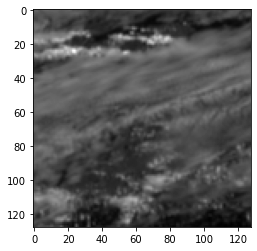

In [11]:
plt.imshow(x[-1], cmap='gray')

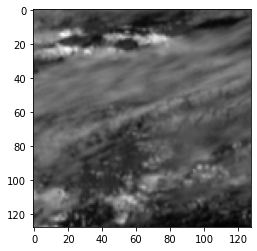

In [17]:
plt.imshow(y[0], cmap='gray')

In [18]:
print(f'The model has {utils.count_parameters(model)} trainable parameters')

The model has 485391266 trainable parameters


In [56]:
model.eval()
criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=24)

scores_unet = []
scores_flow = []
scores_pers = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl)

test_params = {
    "pyr_scale": 0.5,
    "levels": 2,
    "winsize": 40,
    "iterations": 3,
    "poly_n": 5,
    "poly_sigma": 0.7,
}

LOOKS = 63
all_preds = []
for i, (srcs, trgs) in enumerate(pbar):
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    elif i > LOOKS:
        break

    # UNET
    with torch.no_grad():
        preds = model(x)
    
    all_preds.append(preds.detach().cpu().numpy())
    
    score = utils.get_mssim(preds, y, average=False)
    score = score.detach().cpu().numpy()
    scores_unet.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    # FLOW
    ycrop = y[:,:,32:96,32:96]
    batch_flow_scores = np.zeros((len(x), 24), dtype=np.float32)
    for b in range(len(x)):
        flow = cv2.calcOpticalFlowFarneback(
            prev=x[b,-1,0].detach().cpu().numpy(),
            next=x[b,-2,0].detach().cpu().numpy(),
            flow=None,
            **test_params,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
        )
        flow = -flow
        start = x[b,-1,0].detach().cpu().numpy().astype(np.float32)
        preds = np.zeros((24, 64, 64), dtype=np.float32)
        for j in range(24):
            img = utils.warp_flow(start, flow*(j+1))
            preds[j] = img[32:96,32:96]
        preds = torch.FloatTensor(preds).to(DEVICE)
        score = utils.get_msssim(preds, ycrop[b], average=False, inner_64=False)
        score = score.detach().cpu().numpy()
        batch_flow_scores[b] = score
    scores_flow.append(batch_flow_scores)
        
    # PERSISTENCE
    # grab the last image and tile it as the prediction
    preds = torch.tile(x[:,-1:,0], (1,24,1,1))
    score = utils.get_msssim(preds, y, average=False)
    score = score.detach().cpu().numpy()
    scores_pers.append(score)
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

Avg Score: 0.8783564176410437:   2%|▏         | 64/2617 [00:23<15:18,  2.78it/s]


In [57]:
all_preds = np.concatenate(all_preds, axis=0)
scores_unet = np.concatenate(scores_unet, axis=0)
scores_flow = np.concatenate(scores_flow, axis=0)
scores_pers = np.concatenate(scores_pers, axis=0)

In [58]:
scores_unet.shape, scores_flow.shape, scores_pers.shape

((1009, 24), (1009, 24), (1009, 24))

In [59]:
mean_unet = scores_unet.mean(axis=0)
mean_flow = scores_flow.mean(axis=0)
mean_pers = scores_pers.mean(axis=0)

Text(0, 0.5, 'MS-SSIM')

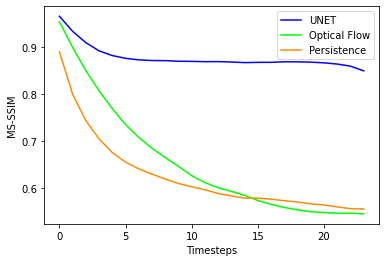

In [60]:
# keep in mind this is on the data UNET was trained on, so it's a bit overfit
# the test set reports smaller numbers
x = np.arange(24)
plt.plot(x, mean_unet, label='UNET', color='blue')
plt.plot(x, mean_flow, label='Optical Flow', color='lime')
plt.plot(x, mean_pers, label='Persistence', color='darkorange')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('MS-SSIM')

In [64]:
plt.rc('animation', html='jshtml')
from matplotlib import animation


def plot_animation(input_images, images, model_images):
    fig, (ax_true, ax_flow, ax_dgmr) = plt.subplots(1, 3, figsize=(15,15))
    plt.tight_layout()
    plt.close() # Prevents extra axes being plotted below animation

    img_true = ax_true.imshow(images[0], cmap='gray')
    img_dgmr = ax_dgmr.imshow(model_images[0], cmap='gray')
    img_flow = ax_flow.imshow(input_images[0], cmap='gray')
    
    test_params = {
        "pyr_scale": 0.5,
        "levels": 2,
        "winsize": 40,
        "iterations": 3,
        "poly_n": 5,
        "poly_sigma": 0.7,
    }
    flow = cv2.calcOpticalFlowFarneback(
        prev=input_images[-1],
        next=input_images[-2],
        flow=None,
        **test_params,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
    )
    flow = -flow
    base_flow_img = input_images[-1].astype(np.float32)

    def animate(i):
        nonlocal images, model_images
        ref = images[i]
        pred_img = model_images[i]
        flow_img = utils.warp_flow(base_flow_img, flow*(i+1))
        pers_img = input_images[-1]
        
        pers_score = utils.get_msssim(pers_img, ref)
        pred_score = utils.get_msssim(pred_img, ref)
        flow_score = utils.get_msssim(flow_img, ref)
        
        ax_true.title.set_text(f'Step {i} Ground Truth. Persistence MS-SSIM: {pers_score:.5f}')
        ax_flow.title.set_text(f'Step {i} Optical Flow MS-SSIM: {flow_score:.5f}')
        ax_dgmr.title.set_text(f'Step {i} UNET MS-SSIM: {pred_score:.5f}')
        return img_true.set_data(images[i]), img_flow.set_data(flow_img), img_dgmr.set_data(pred_img)

    return animation.FuncAnimation(fig, animate, frames=images.shape[0], interval=1000, blit=False)


In [71]:
idx = 0
x, y = ds[idx]
x = x.numpy()
y = y.numpy()
anim = plot_animation(x, y, all_preds[idx_all_preds])
anim

In [72]:
import matplotlib.animation as animation
writergif = animation.PillowWriter(fps=3) 
anim.save('model_predictions.gif', writer=writergif)